In [0]:
# Install regression algorithm
#%pip install xgboost

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import sum, col, min, max, to_timestamp, to_date, date_format, round
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score, explained_variance_score

In [0]:
# Load data into dataframes
dfR1_o = sqlContext.read.load('/FileStore/tables/restaurant_1_orders.csv', format='csv', header=True, inferSchema=True)

## Data exploration

In [0]:
# First glance over data using display() function
display(dfR1_o.limit(10))

Order Number,Order Date,Item Name,Quantity,Product Price,Total products
16118,03/08/2019 20:25,Plain Papadum,2,0.8,6
16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6
16118,03/08/2019 20:25,Mango Chutney,1,0.5,6
16117,03/08/2019 20:17,Plain Naan,1,2.6,7
16117,03/08/2019 20:17,Mushroom Rice,1,3.95,7
16117,03/08/2019 20:17,Tandoori Chicken (1/4),1,4.95,7
16117,03/08/2019 20:17,Vindaloo - Lamb,1,7.95,7


In [0]:
# Grouping by Item Name
display(dfR1_o.groupBy("Item Name").sum().orderBy("sum(Total Products)",ascending=0).limit(10))

Item Name,sum(Order Number),sum(Quantity),sum(Product Price),sum(Total products)
Pilau Rice,43450300,6367,13926.95000000106,31314
Plain Papadum,33504914,10648,2878.4000000001065,27140
Plain Naan,33978950,4983,9757.80000000069,24276
Onion Bhajee,21818221,2749,9487.899999999972,17293
Garlic Naan,23930176,3318,7752.599999999671,17143
Mango Chutney,19194045,2504,1035.0,16991
Plain Rice,21315452,2964,6988.549999999718,15345
Chicken Tikka Masala,19303060,2473,19090.350000000766,14439
Mint Sauce,13604320,1840,731.5,12615
Bombay Aloo,16083952,1831,10424.400000000096,12373


##Data cleaning

### Checking for null values


In [0]:
# Create an empty list to store info about null values
nulls = []

# Iterate over each column in the DataFrame, for reach check if it is null, convert booleans to integer and then sum all values in a column -> if no null, sum will be 0
for column in dfR1_o.columns:
    nulls_sum = sum(col(column).isNull().cast("int")).alias(column) # alias to name the new column in expr the same as the original
    nulls.append(nulls_sum)

# Use the list of expressions in the select statement to build a new DataFrame
nulls_df = dfR1_o.select(*nulls)

# Display the DataFrame with the count of NULL values for each column
display(nulls_df)

Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,0,0,0,0,0


### Checking for duplicates

In [0]:
# To check for duplicates, create a new DF without duplicates, then count rows in both new and old DF and compare
unique_df1 = dfR1_o.dropDuplicates()
total_count = dfR1_o.count()
unique_count = unique_df1.count()
duplicate_count = total_count - unique_count
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 97


In [0]:
# Easiest way to see data types
dfR1_o.printSchema()

root
 |-- Order Number: integer (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Item Name: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Product Price: double (nullable = true)
 |-- Total products: integer (nullable = true)



### Formatting

We can see that Order Date is a string, which won't work. So format to datetime instead.

In [0]:
# Convert the string column "date_str" into a timestamp column "datetime"
df = dfR1_o.withColumn("Timestamp", to_timestamp(col("Order Date"), "dd/MM/yyyy HH:mm"))

# Delete string date column
df = df.drop('Order Date')

# Separate date and time into separate varibles
df = df.withColumn("Order Date", to_date(col("Timestamp")))
df = df.withColumn("Order Time", date_format(col("Timestamp"), "HH:mm"))

# Calculating total value of order as product prince * number of products, round up to 2 decimals
df = df.withColumn("Value", round(col("Product Price") * col("Total products"), 2))

# Check data
display(df.limit(10))

Order Number,Item Name,Quantity,Product Price,Total products,Timestamp,Order Date,Order Time,Value
16118,Plain Papadum,2,0.8,6,2019-08-03T20:25:00.000+0000,2019-08-03,20:25,4.8
16118,King Prawn Balti,1,12.95,6,2019-08-03T20:25:00.000+0000,2019-08-03,20:25,77.7
16118,Garlic Naan,1,2.95,6,2019-08-03T20:25:00.000+0000,2019-08-03,20:25,17.7
16118,Mushroom Rice,1,3.95,6,2019-08-03T20:25:00.000+0000,2019-08-03,20:25,23.7
16118,Paneer Tikka Masala,1,8.95,6,2019-08-03T20:25:00.000+0000,2019-08-03,20:25,53.7
16118,Mango Chutney,1,0.5,6,2019-08-03T20:25:00.000+0000,2019-08-03,20:25,3.0
16117,Plain Naan,1,2.6,7,2019-08-03T20:17:00.000+0000,2019-08-03,20:17,18.2
16117,Mushroom Rice,1,3.95,7,2019-08-03T20:17:00.000+0000,2019-08-03,20:17,27.65
16117,Tandoori Chicken (1/4),1,4.95,7,2019-08-03T20:17:00.000+0000,2019-08-03,20:17,34.65
16117,Vindaloo - Lamb,1,7.95,7,2019-08-03T20:17:00.000+0000,2019-08-03,20:17,55.65


### Figuring out the timeline

In [0]:
time_period = df.groupBy("Order Date").count().orderBy("Order Date", ascending=1)
display(time_period.limit(10))

Order Date,count
2015-09-01,1
2015-09-08,3
2015-09-09,6
2015-09-29,6
2015-09-30,13
2015-10-01,20
2015-10-02,19
2016-03-07,17
2016-03-08,8
2016-03-09,7


In [0]:
min_df = df.select(date_format(min(col("Order Date")), "yyyy-MM-dd").alias("min_date"))
max_df = df.select(date_format(max(col("Order Date")), "yyyy-MM-dd").alias("max_date"))

earliest = min_df.collect()[0]['min_date']
latest = max_df.collect()[0]['max_date']

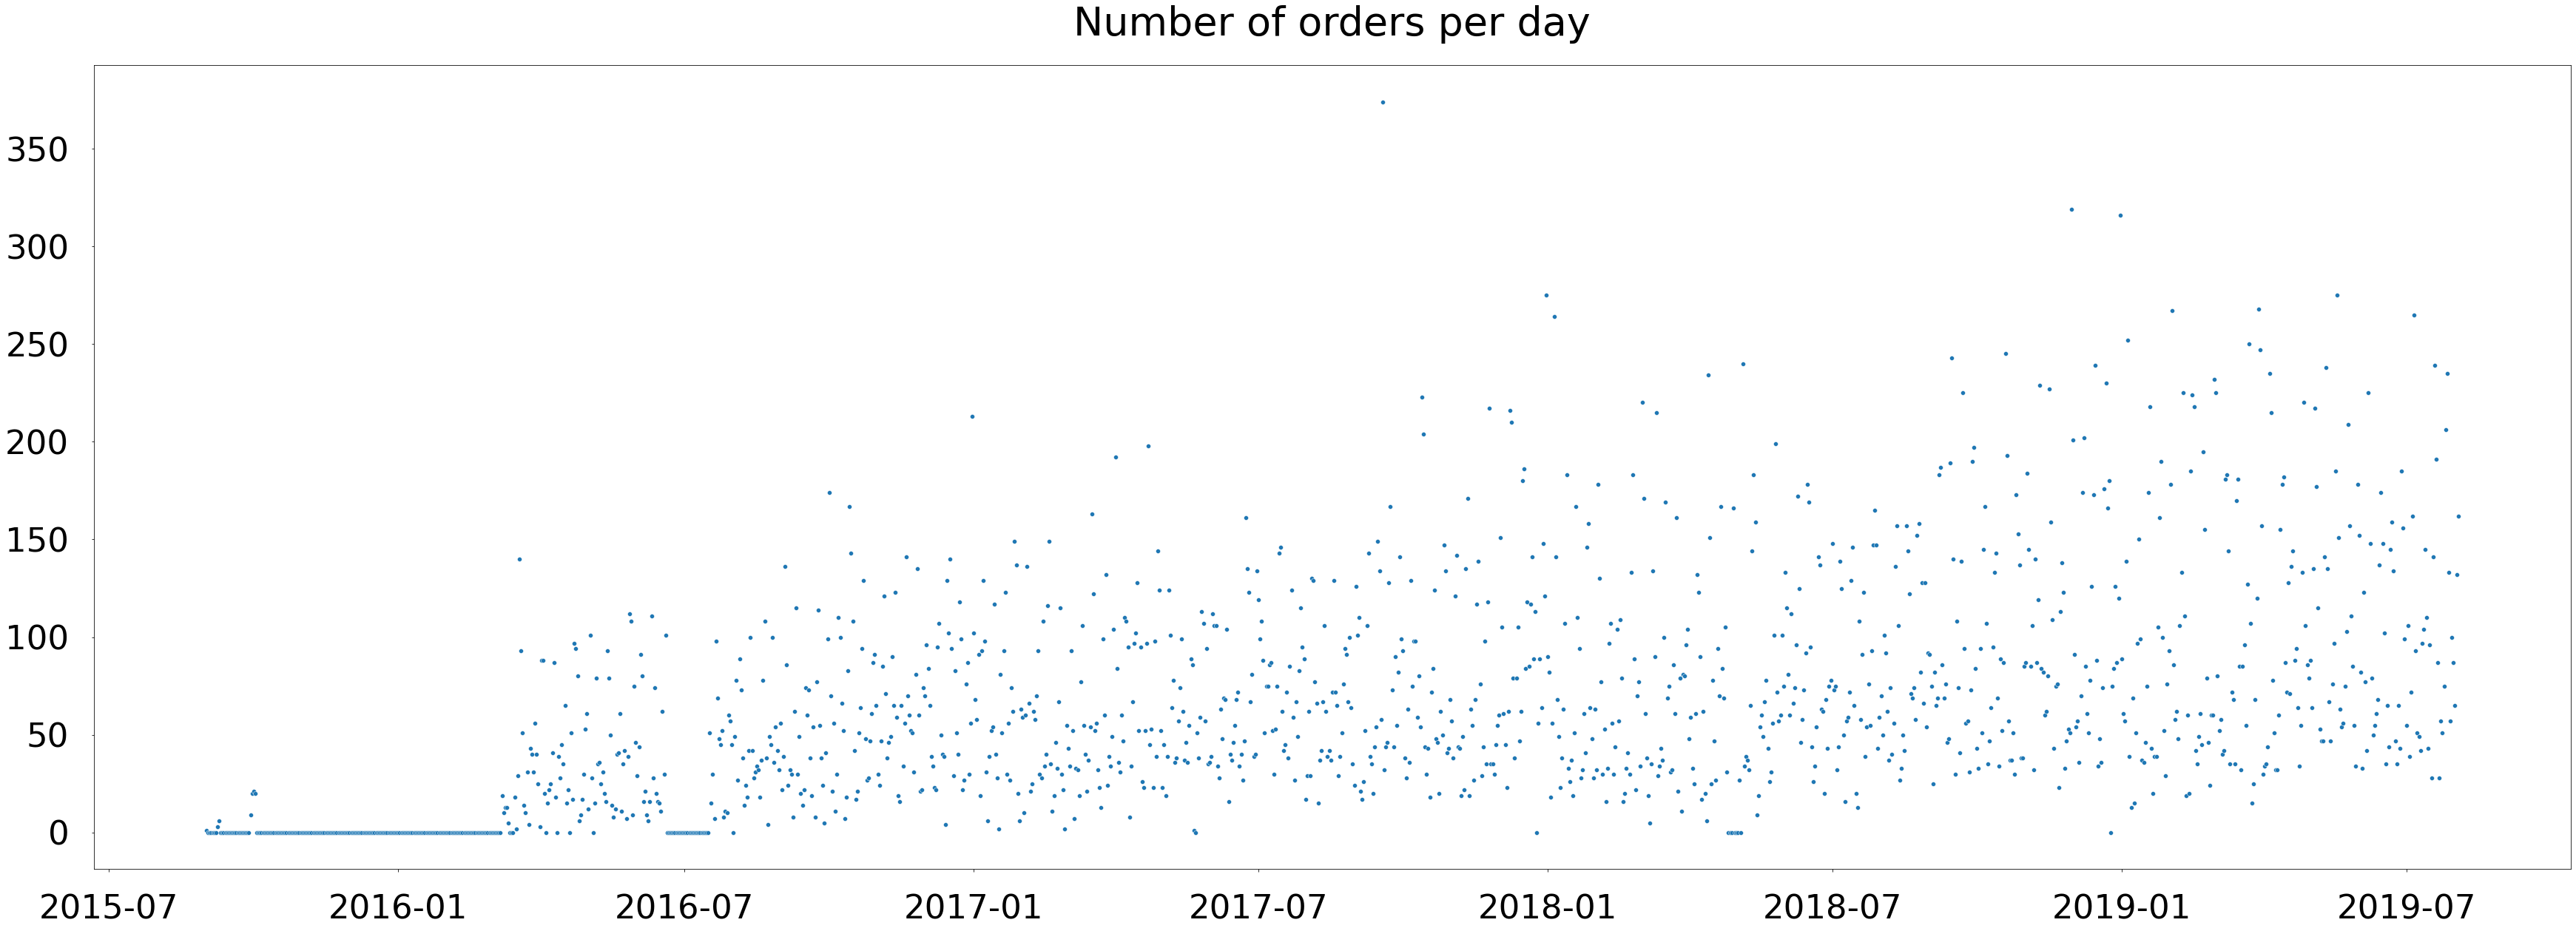

In [0]:
# Convert the Spark DataFrame to a Pandas DataFrame
df_pd = df.toPandas()

# Date needs to contain dataframe objects to use resample()
df_pd['Order Date'] = pd.to_datetime(df_pd['Order Date'])

#first we group orders by day, summing total products
df_pd = df_pd[['Order Date', 'Quantity']].resample('D', on='Order Date').sum().reset_index()

# Create a list of xticks using Pandas date_range (if needed)
year_ticks = pd.date_range(start=earliest, end=latest, freq='2MS')

# Plotting with seaborn
plt.figure(figsize=(60, 20))
fig = sns.scatterplot(x=df_pd['Order Date'], y=df_pd['Quantity'])

# Set font size for all text
plt.rcParams.update({'font.size': 45})

# Remove the tick marks (small lines) next to the numbers, set title
plt.title("Number of orders per day", pad=40)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

The graphs shows that there are inconsistencies for the earliest dates, mostly in year 2015 and in the summer of 2016.

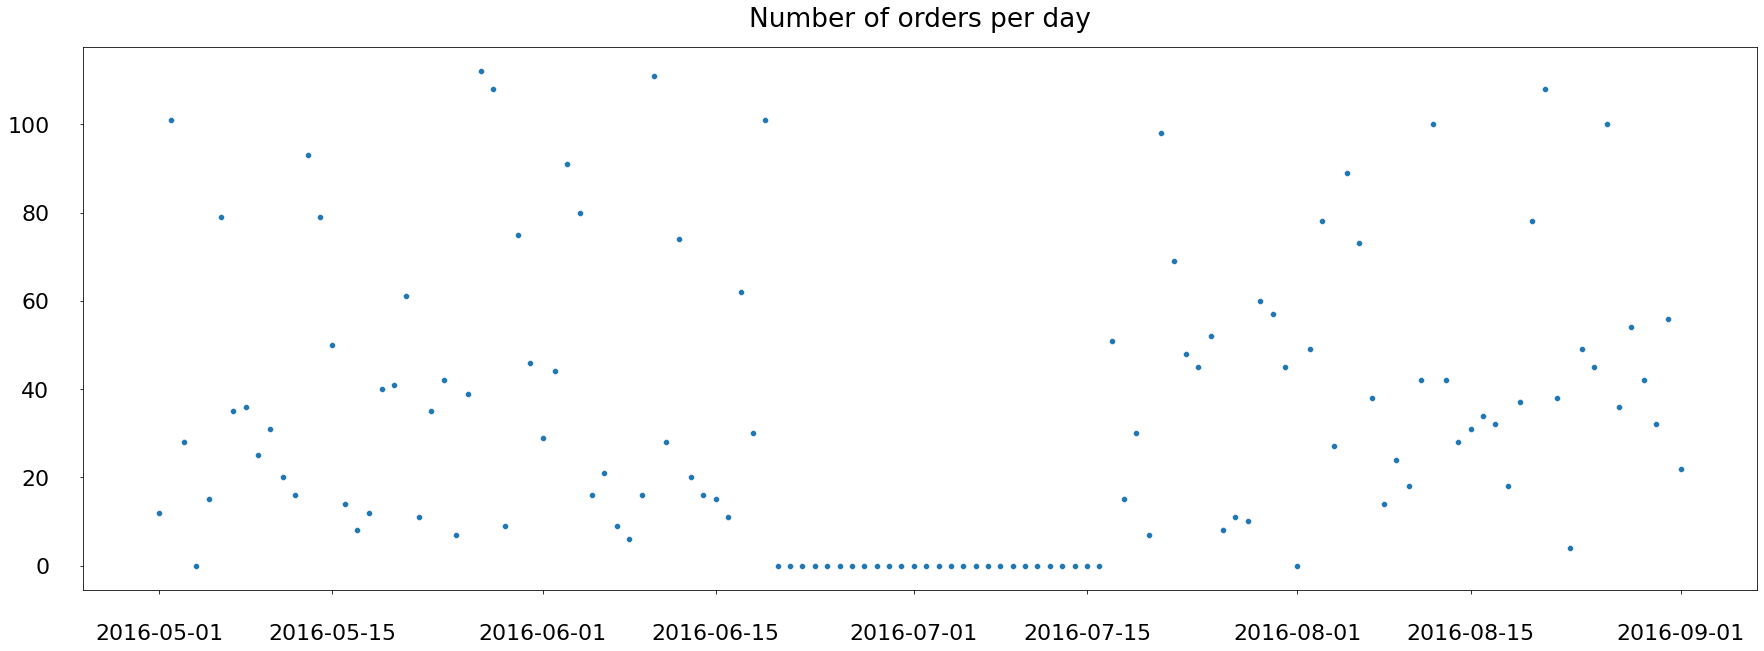

In [0]:
# Define your date boundaries (make sure they are in a comparable format)
date1 = "2016-05-01"
date2 = "2016-09-01"

# Filter the DataFrame to include only rows between date1 and date2,
# then group by "Date", count, and order the results.
df_pd1 = (
    df.filter((col("Order Date") >= date1) & (col("Order Date") <= date2))
)

# Convert the Spark DataFrame to a Pandas DataFrame
df_pd1 = df_pd1.toPandas()

# Date needs to contain dataframe objects to use resample()
df_pd1['Order Date'] = pd.to_datetime(df_pd1['Order Date'])

#first we group orders by day, summing total products
df_pd1 = df_pd1[['Order Date', 'Quantity']].resample('D', on='Order Date').sum().reset_index()

# Create a list of xticks using Pandas date_range (if needed)
year_ticks = pd.date_range(start=date1, end=date2, freq='1MS')

# Plotting with seaborn
plt.figure(figsize=(30, 10))
fig = sns.scatterplot(x=df_pd1['Order Date'], y=df_pd1['Quantity'])

# Set font size for all text
plt.rcParams.update({'font.size': 22})

# Remove the tick marks (small lines) next to the numbers, set title
plt.title("Number of orders per day", pad=20)
plt.xlabel(None)
plt.ylabel(None)
plt.show()



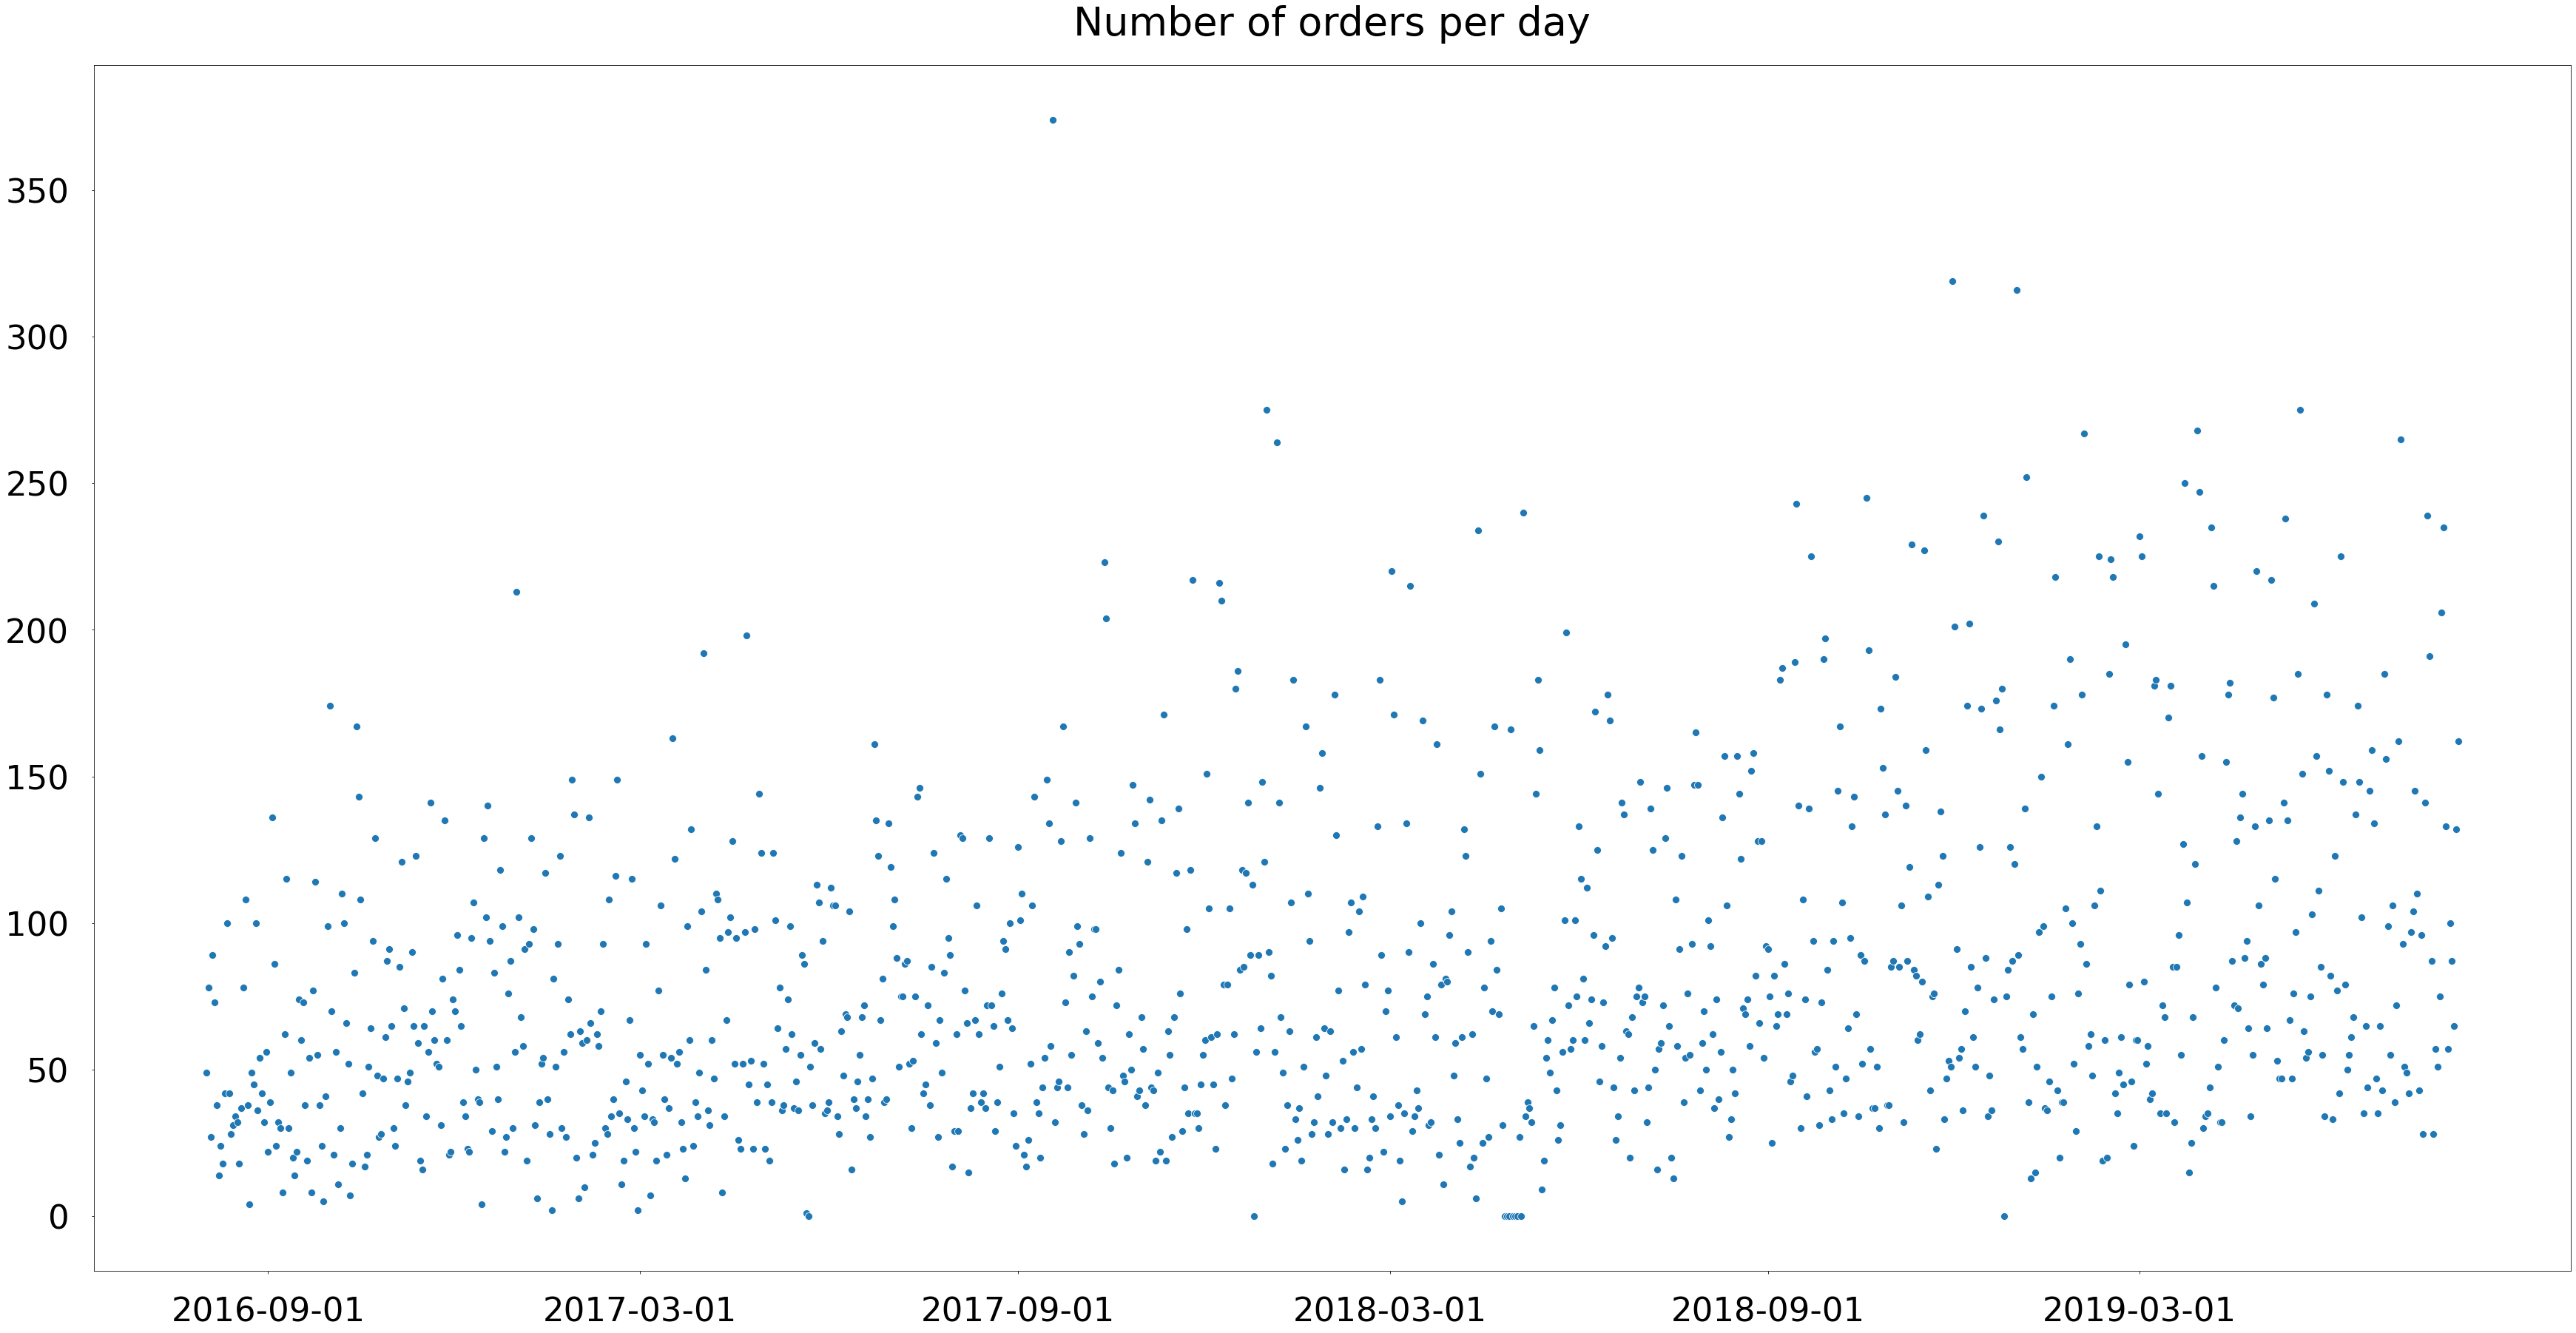

In [0]:
# Define your date boundaries (make sure they are in a comparable format)
start_date = "2016-08-01"

# Filter the DataFrame to include only rows after start_date,
# then group by "Date", count, and order the results.
df_F = (
    df.filter((col("Order Date") >= start_date))
)

# Calculate new min and max dates
min_df = df_F.select(date_format(min(col("Order Date")), "yyyy-MM-dd").alias("min_date"))
max_df = df_F.select(date_format(max(col("Order Date")), "yyyy-MM-dd").alias("max_date"))

earliest = min_df.collect()[0]['min_date']
latest = max_df.collect()[0]['max_date']

# Convert the Spark DataFrame to a Pandas DataFrame
df_F = df_F.toPandas()

# Date needs to contain dataframe objects to use resample()
df_F['Order Date'] = pd.to_datetime(df_F['Order Date'])

#first we group orders by day, summing total products
df_F = df_F[['Order Date', 'Quantity']].resample('D', on='Order Date').sum().reset_index()

# Create a list of xticks using Pandas date_range (if needed)
year_ticks = pd.date_range(start=earliest, end=latest, freq='6MS')

# Plotting with seaborn
plt.figure(figsize=(60, 30))
fig = sns.scatterplot(x=df_F['Order Date'], y=df_F['Quantity'], s=100)

# Set font size for all text
plt.rcParams.update({'font.size': 45})

# Set the x-ticks (this assumes your x-axis uses datetime objects)
#plt.xticks([])  # rotation is optional, for better readability
plt.xticks(year_ticks)

# Remove the tick marks (small lines) next to the numbers, set title
plt.title("Number of orders per day", pad=40)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

### Creating weakly averages

In [0]:
orders = df_F[["Order Date", "Quantity"]]
orders = orders.groupby([pd.Grouper(key='Order Date', freq='W-MON')])['Quantity'].sum().reset_index().sort_values('Order Date')

#Add Seasonality features
orders['Week'] = orders['Order Date'].dt.isocalendar().week
orders['Month'] = orders['Order Date'].dt.month

#Add past volume features
for i in range (1,15):
    label = "Quantity_" + str(i)
    orders[label] = orders['Quantity'].shift(i)
    label = "Average_" + str(i)
    orders[label] = orders['Quantity'].rolling(i).mean()
orders = orders.dropna()

#one hot encode orders using pandas get_dummies
for column in ['Week','Month']:
    tempdf = pd.get_dummies(orders[column], prefix=column)
    orders = pd.merge(
        left=orders,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    orders = orders.drop(columns=column)
orders.shape

Out[25]: (143, 94)

In [0]:
# Splitting the data into train (75%) and test (25%) data
# 75% of 143 is 107
train = orders[:107].drop('Order Date', axis = 1)
test = orders[107:].drop('Order Date', axis = 1)
xtrain = train.drop(['Quantity'], axis = 1)
xtest = test.drop(['Quantity'], axis = 1)
ytrain = train['Quantity']
ytest =test['Quantity']

### Building the model

In [0]:
# Initialize the model
model = XGBRegressor(n_estimators=500, learning_rate=0.01)

# Prepare the evaluation set (using training data for demonstration)
eval_set = [(xtrain, ytrain)]

# Fit the model with the evaluation metric and early stopping
model.fit(xtrain, ytrain, eval_set=eval_set, verbose=False)

# Make predictions on the test set
ypred = model.predict(xtest)

In [0]:
#First we add the results to our original dataframe, after first aligning the indexes
ypred = pd.Series(ypred)

# Take 75% of data for testing
eval_df = orders[107:].reset_index(drop = True)
eval_df['ypred'] = ypred
eval_df = eval_df[['Order Date','Quantity', 'ypred']]
#display(eval_df)

#display(eval_df.drop(eval_df.index[[0,1,2,3,4,5,6,7,8,9]]))

new_df = eval_df.drop(eval_df.index[[0,1,2,3,4,5,6,7,8,9,10,11]])

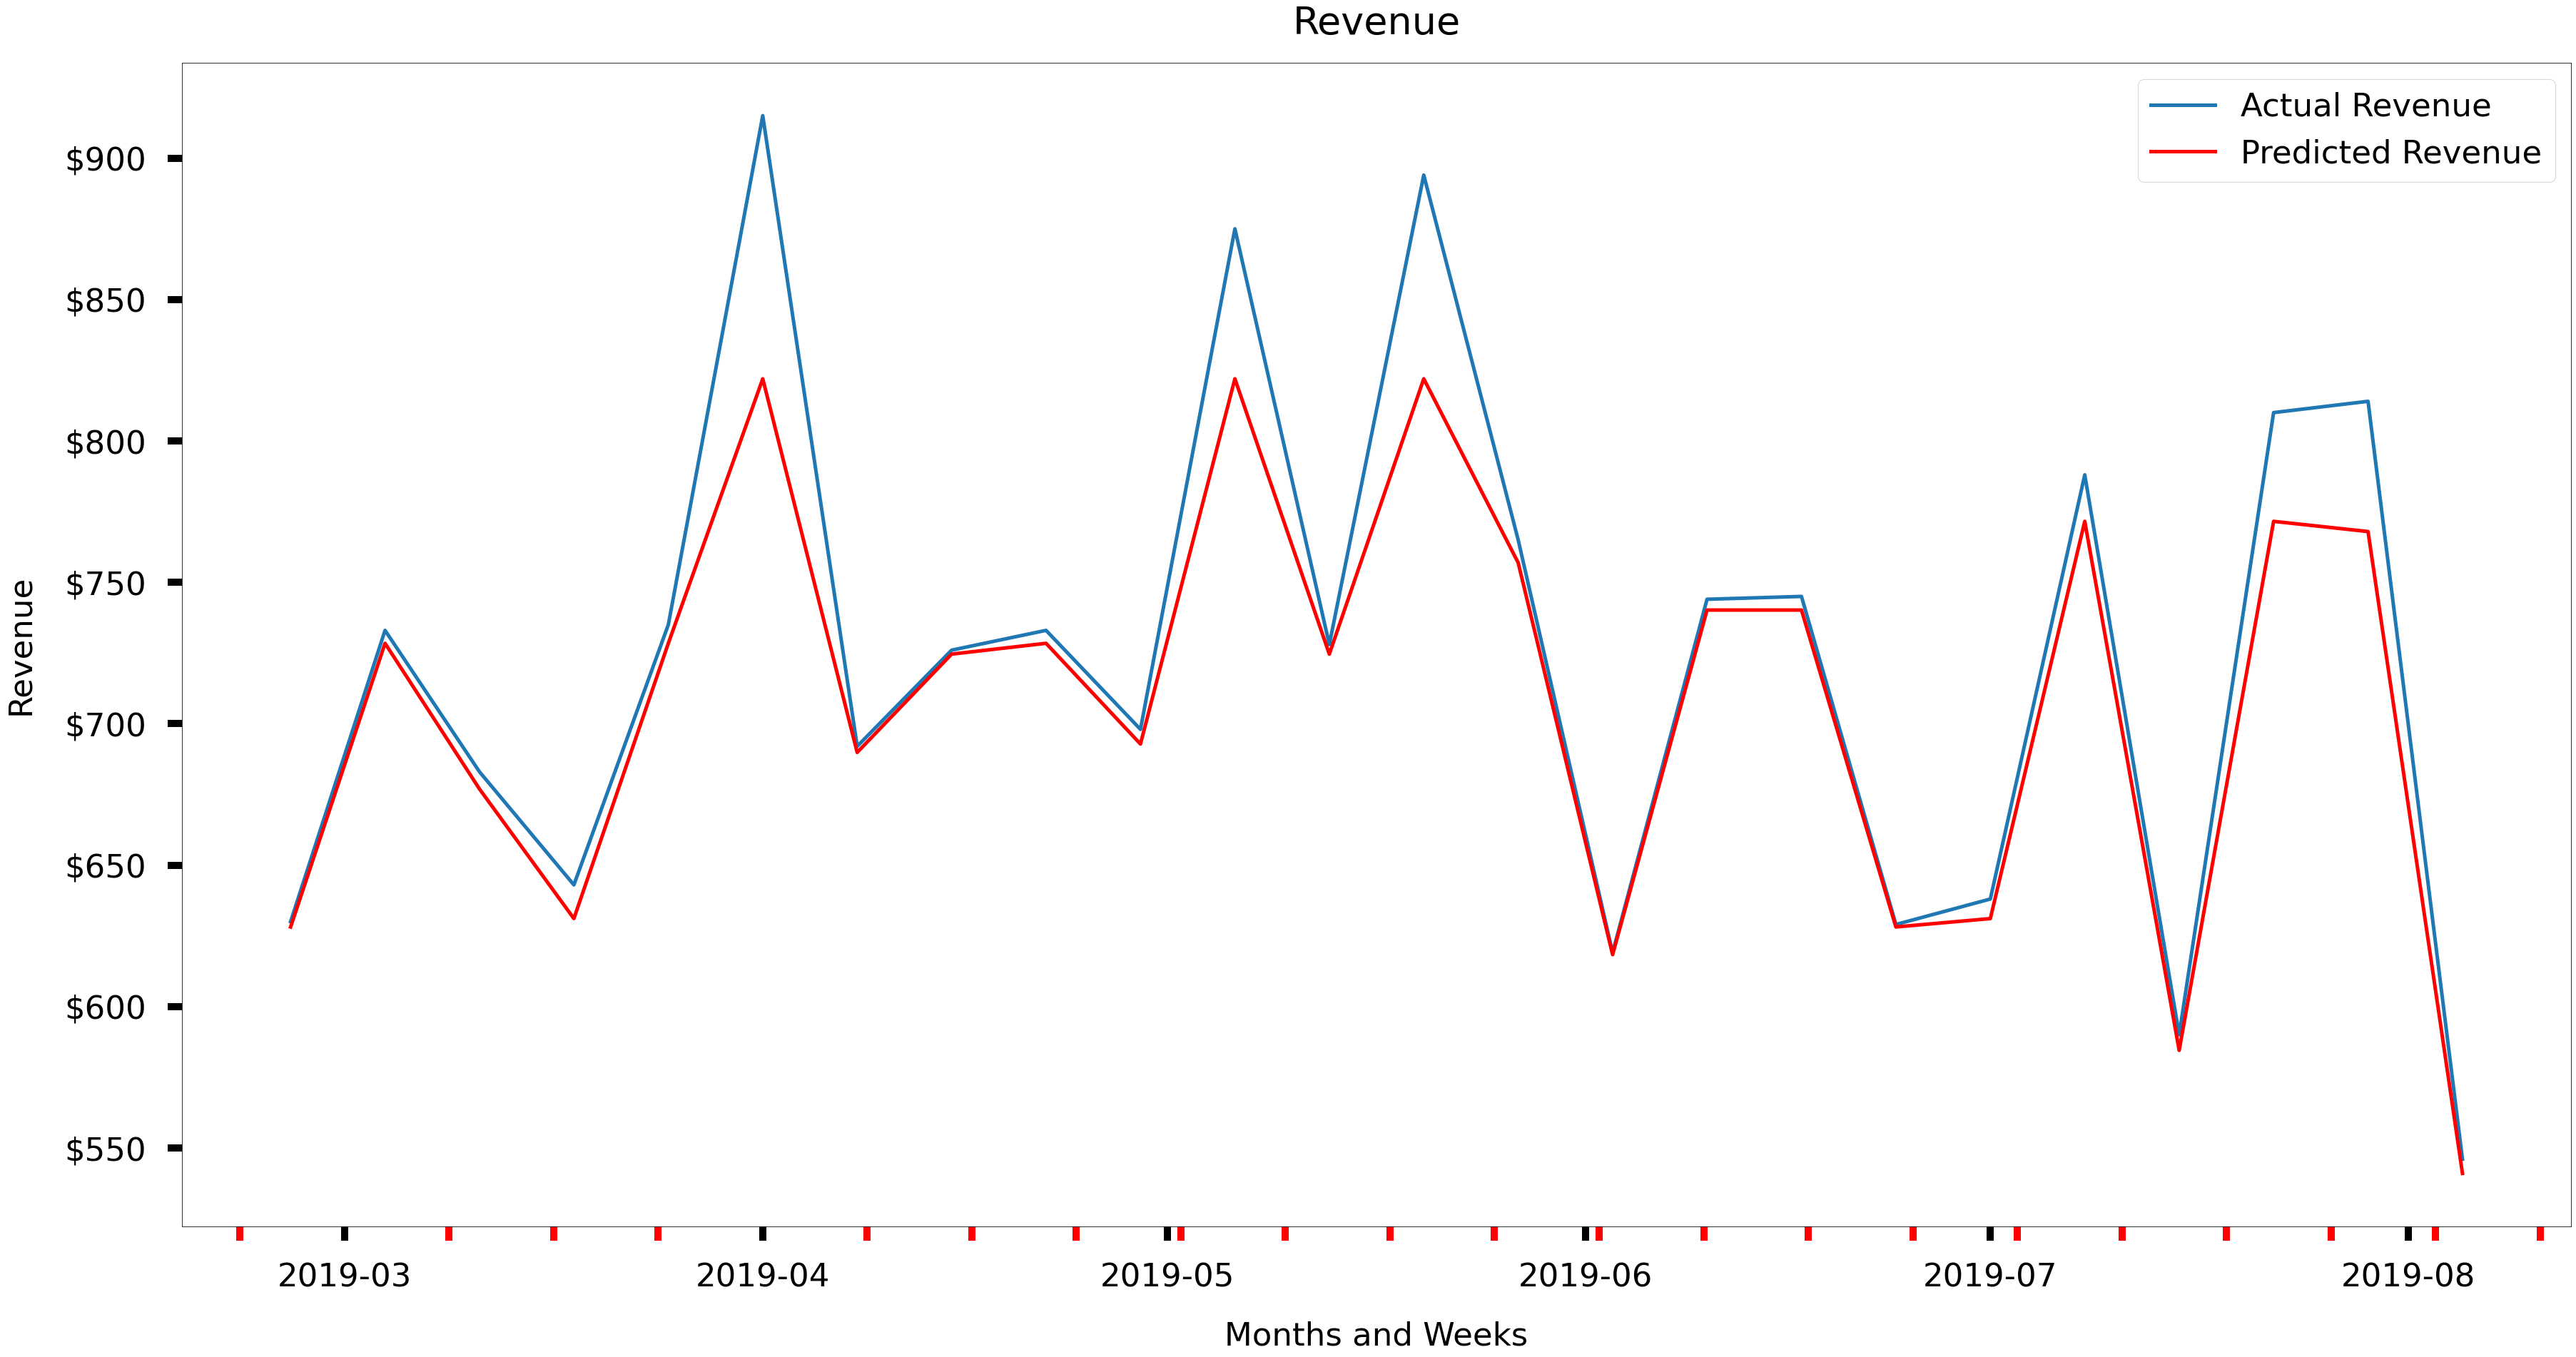

In [0]:
# Plotting the results of the train vs test sets
# Create the plot, define size
fig, ax = plt.subplots(figsize=(60, 30))

# Define lines for actual and predicted values
plt.plot(new_df['Order Date'], new_df['Quantity'], label = "Actual Revenue", linewidth=5)
plt.plot(new_df['Order Date'], new_df['ypred'], color = 'red', label = 'Predicted Revenue', linewidth=5)

# Set font size
plt.rcParams.update({'font.size': 45})

# Set labels and sizes
plt.rcParams['xtick.major.pad']='30'
plt.rcParams['ytick.major.pad']='30'
plt.xlabel('Months and Weeks', labelpad=40)
plt.ylabel('Revenue', labelpad=40)
plt.legend()
plt.title("Revenue", pad=40)

#import locator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax.xaxis.set_minor_locator(AutoMinorLocator())

# Settings for ticks
ax.tick_params(which='both', width=10)
ax.tick_params(which='major', length=20)
ax.tick_params(which='minor', length=20, color='r')

# Import funcformatter for adding $ sign
from matplotlib.ticker import FuncFormatter

# Define the function to format the y-axis ticks with a dollar sign
def dollar_formatter(x, pos):
    return f'${x:,.0f}'  # Adds dollar sign and comma formatting
# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(dollar_formatter))


In [0]:
# DISPLAY metrics - mean_absolute_error, r2_score, mean_squared_log_error
print("Metrics for Total Sale\n")
print("Mean Absolute Error:\n", mean_absolute_error(ytest, ypred))
print("R Squared:\n", r2_score(ytest, ypred))
print("Mean Squared Log Error:\n", mean_squared_log_error(ytest, ypred))


Metrics for Total Sale

Mean Absolute Error:
 19.20262993706597
R Squared:
 0.8969090618945273
Mean Squared Log Error:
 0.0013732105872758815
